In [1]:
import pandas as pd
from keras.callbacks import History, ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
import os
import numpy as np
from data_analysis import calculate_metrics, load_weights_and_evaluate
from model_builders import GCN_pretraining

Using TensorFlow backend.
C:\Users\user\Miniconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# GCN with pretraining functionality parameters

In [2]:
# Specify model callbacks on training
es = EarlyStopping(monitor='loss',patience=8, min_delta=0)
rlr = ReduceLROnPlateau(monitor='loss',factor=0.5, patience=4, verbose=1, min_lr=0.0000001)

encoder_params = {
        "num_layers" : 3,
        "max_atoms" : 70,
        "num_atom_features" : 62,
        "num_atom_features_original" : 62,
        "num_bond_features" : 6,
        "max_degree" : 5,
        "conv_width" : [96,104,120],
        "fp_length" : [160,160,160],
        "activ_enc" : "selu",
        "activ_dec" : "selu",
        "learning_rates" : [0.001,0.001,0.001],
        "learning_rates_fp": [0.005,0.005,0.005],
        "losses_conv" : {
                    "neighbor_output": "mean_squared_error",
                    "self_output": "mean_squared_error",
                    },
        "lossWeights" : {"neighbor_output": 1.0, "self_output": 1.0},
        "metrics" : "mse",
        "loss_fp" : "mean_squared_error",
        "enc_layer_names" : ["enc_1", "enc_2", "enc_3"],
        'callbacks' : [es,rlr],
        'adam_decay': 0.0005329142291371636,
        'beta': 5,
        'p': 0.004465204118126482
        }
model_params = {
        'dense_size' : [256,192,96],
        'dropout_rate' : [0.354,0.354],
        'lr' : 0.007
}

# Load train, val, test data

In [9]:
base_path = 'C:/Users/user/Documents/kinase_binding/learning/'
target = 'p38'
model_name = 'gcn_pretraining_ensemble_optimized'

In [10]:
# no need for manual changes in this cell
train_files = os.path.join(base_path, f'data/{target}/split_aveb/fold_{{}}/train_{{}}.csv')
val_files = os.path.join(base_path, f'data/{target}/split_aveb/fold_{{}}/val_{{}}.csv')
weight_files = os.path.join(base_path, f'results/{target}/{model_name}/fold_{{}}/model_weights/model_{{}}.h5')

In [11]:
train_sets = [pd.read_csv(train_files.format(i,i), index_col = 0) if 'Unnamed: 0' in pd.read_csv(train_files.format(i,i)) else pd.read_csv(train_files.format(i,i)) for i in range(7)]
val_sets = [pd.read_csv(val_files.format(i,i), index_col = 0) if 'Unnamed: 0' in pd.read_csv(val_files.format(i,i)) else pd.read_csv(val_files.format(i,i)) for i in range(7)]
test_set = pd.read_csv(os.path.join(base_path, f'data/{target}/split_aveb/test.csv')) 

# Cross validation and test predictions

In [16]:
n_ensemble = 5

In [17]:
val_preds = []
test_preds = []
gcn = GCN_pretraining(encoder_params,model_params)
for i in [0,1,2,3,4,5,6]:
    en_val_preds = []
    en_test_preds = []
    X_atoms_cold,X_bonds_cold,X_edges_cold = gcn.dataframe_to_gcn_input(val_sets[i])
    Y_cold = val_sets[i].Binary
    X_atoms_train, X_bonds_train, X_edges_train = gcn.dataframe_to_gcn_input(train_sets[i])
    Y = train_sets[i].Binary
    X_atoms_test, X_bonds_test, X_edges_test = gcn.dataframe_to_gcn_input(test_set)
    for j in range(n_ensemble):
        gcn_encoder = gcn.build_encoder()
        gcn_model = gcn.build_model(gcn_encoder)
        gcn_model.fit([X_atoms_train,X_bonds_train,X_edges_train],Y,
                    batch_size=64,
                    epochs=35,
                    verbose=2,
                    shuffle=True,
                    validation_data=([X_atoms_cold,X_bonds_cold,X_edges_cold],Y_cold))
        y_pred_val = gcn_model.predict([X_atoms_cold,X_bonds_cold,X_edges_cold])
        y_pred_test = gcn_model.predict([X_atoms_test,X_bonds_test,X_edges_test])
        en_val_preds.append(y_pred_val)
        en_test_preds.append(y_pred_test)
        gcn_model.save_weights(os.path.join(base_path, f'results/{target}/{model_name}/fold_%s/model_weights/model_%s.h5'%(i,j)))
    val_preds.append(np.mean(en_val_preds, axis = 0))
    test_preds.append(np.mean(en_test_preds, axis = 0))

LAYER 0
LAYER 1
LAYER 2


C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2804 samples, validate on 382 samples
Epoch 1/35
 - 8s - loss: 0.6844 - acc: 0.5699 - val_loss: 0.7533 - val_acc: 0.4503
Epoch 2/35
 - 1s - loss: 0.6190 - acc: 0.6690 - val_loss: 0.6243 - val_acc: 0.6806
Epoch 3/35
 - 2s - loss: 0.5595 - acc: 0.7183 - val_loss: 0.6401 - val_acc: 0.6911
Epoch 4/35
 - 1s - loss: 0.5518 - acc: 0.7190 - val_loss: 0.5928 - val_acc: 0.6859
Epoch 5/35
 - 2s - loss: 0.5285 - acc: 0.7315 - val_loss: 0.6434 - val_acc: 0.6414
Epoch 6/35
 - 1s - loss: 0.5114 - acc: 0.7518 - val_loss: 0.5822 - val_acc: 0.6911
Epoch 7/35
 - 2s - loss: 0.4836 - acc: 0.7739 - val_loss: 0.7915 - val_acc: 0.6623
Epoch 8/35
 - 1s - loss: 0.4850 - acc: 0.7625 - val_loss: 0.6636 - val_acc: 0.6597
Epoch 9/35
 - 1s - loss: 0.4785 - acc: 0.7732 - val_loss: 0.6714 - val_acc: 0.6702
Epoch 10/35
 - 1s - loss: 0.4718 - acc: 0.7636 - val_loss: 0.6545 - val_acc: 0.6492
Epoch 11/35
 - 1s - loss: 0.4578 - acc: 0.7924 - val_loss: 0.6096 - val_acc: 0.6702
Epoch 12/35
 - 1s - loss: 0.4607 - acc

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2804 samples, validate on 382 samples
Epoch 1/35
 - 9s - loss: 0.7000 - acc: 0.5157 - val_loss: 0.7015 - val_acc: 0.3429
Epoch 2/35
 - 1s - loss: 0.6295 - acc: 0.6484 - val_loss: 0.6261 - val_acc: 0.6204
Epoch 3/35
 - 1s - loss: 0.5890 - acc: 0.6879 - val_loss: 0.5542 - val_acc: 0.7461
Epoch 4/35
 - 1s - loss: 0.5466 - acc: 0.7250 - val_loss: 0.6067 - val_acc: 0.7016
Epoch 5/35
 - 1s - loss: 0.5485 - acc: 0.7175 - val_loss: 0.5795 - val_acc: 0.7016
Epoch 6/35
 - 1s - loss: 0.5162 - acc: 0.7489 - val_loss: 0.5782 - val_acc: 0.7225
Epoch 7/35
 - 1s - loss: 0.5033 - acc: 0.7500 - val_loss: 0.6567 - val_acc: 0.5524
Epoch 8/35
 - 1s - loss: 0.4961 - acc: 0.7521 - val_loss: 0.5824 - val_acc: 0.7382
Epoch 9/35
 - 1s - loss: 0.5073 - acc: 0.7557 - val_loss: 0.6074 - val_acc: 0.7094
Epoch 10/35
 - 1s - loss: 0.4767 - acc: 0.7678 - val_loss: 0.7639 - val_acc: 0.6780
Epoch 11/35
 - 1s - loss: 0.4684 - acc: 0.7743 - val_loss: 0.5646 - val_acc: 0.7094
Epoch 12/35
 - 1s - loss: 0.4550 - acc

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2804 samples, validate on 382 samples
Epoch 1/35
 - 10s - loss: 0.6895 - acc: 0.5492 - val_loss: 0.5914 - val_acc: 0.7068
Epoch 2/35
 - 1s - loss: 0.6160 - acc: 0.6669 - val_loss: 0.5878 - val_acc: 0.7173
Epoch 3/35
 - 2s - loss: 0.6002 - acc: 0.6844 - val_loss: 0.6104 - val_acc: 0.7016
Epoch 4/35
 - 2s - loss: 0.5496 - acc: 0.7190 - val_loss: 0.5538 - val_acc: 0.6963
Epoch 5/35
 - 2s - loss: 0.5343 - acc: 0.7414 - val_loss: 0.5819 - val_acc: 0.6754
Epoch 6/35
 - 2s - loss: 0.5199 - acc: 0.7340 - val_loss: 0.6198 - val_acc: 0.6885
Epoch 7/35
 - 1s - loss: 0.5058 - acc: 0.7486 - val_loss: 0.6677 - val_acc: 0.6780
Epoch 8/35
 - 2s - loss: 0.5188 - acc: 0.7418 - val_loss: 0.5918 - val_acc: 0.6702
Epoch 9/35
 - 2s - loss: 0.5056 - acc: 0.7571 - val_loss: 0.6179 - val_acc: 0.6754
Epoch 10/35
 - 2s - loss: 0.4942 - acc: 0.7700 - val_loss: 0.6316 - val_acc: 0.6649
Epoch 11/35
 - 2s - loss: 0.5101 - acc: 0.7504 - val_loss: 0.6044 - val_acc: 0.6859
Epoch 12/35
 - 2s - loss: 0.4898 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2804 samples, validate on 382 samples
Epoch 1/35
 - 12s - loss: 0.6921 - acc: 0.5503 - val_loss: 0.8960 - val_acc: 0.3351
Epoch 2/35
 - 2s - loss: 0.6301 - acc: 0.6587 - val_loss: 0.5708 - val_acc: 0.7435
Epoch 3/35
 - 2s - loss: 0.5912 - acc: 0.6990 - val_loss: 0.5980 - val_acc: 0.6885
Epoch 4/35
 - 2s - loss: 0.5565 - acc: 0.7126 - val_loss: 0.7342 - val_acc: 0.6911
Epoch 5/35
 - 2s - loss: 0.5212 - acc: 0.7443 - val_loss: 0.6644 - val_acc: 0.7042
Epoch 6/35
 - 2s - loss: 0.5428 - acc: 0.7379 - val_loss: 0.5940 - val_acc: 0.6728
Epoch 7/35
 - 2s - loss: 0.5124 - acc: 0.7354 - val_loss: 0.6059 - val_acc: 0.7147
Epoch 8/35
 - 2s - loss: 0.4844 - acc: 0.7707 - val_loss: 0.6510 - val_acc: 0.6832
Epoch 9/35
 - 2s - loss: 0.4855 - acc: 0.7628 - val_loss: 0.5968 - val_acc: 0.6885
Epoch 10/35
 - 2s - loss: 0.4521 - acc: 0.7810 - val_loss: 0.5812 - val_acc: 0.7068
Epoch 11/35
 - 2s - loss: 0.4512 - acc: 0.7899 - val_loss: 0.6821 - val_acc: 0.6675
Epoch 12/35
 - 2s - loss: 0.4519 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2804 samples, validate on 382 samples
Epoch 1/35
 - 12s - loss: 0.6978 - acc: 0.5350 - val_loss: 0.6308 - val_acc: 0.6832
Epoch 2/35
 - 2s - loss: 0.6322 - acc: 0.6583 - val_loss: 0.6586 - val_acc: 0.6492
Epoch 3/35
 - 2s - loss: 0.5794 - acc: 0.7076 - val_loss: 0.6516 - val_acc: 0.6204
Epoch 4/35
 - 2s - loss: 0.5501 - acc: 0.7186 - val_loss: 0.5631 - val_acc: 0.7147
Epoch 5/35
 - 2s - loss: 0.5140 - acc: 0.7457 - val_loss: 0.6890 - val_acc: 0.6702
Epoch 6/35
 - 2s - loss: 0.5068 - acc: 0.7482 - val_loss: 0.5387 - val_acc: 0.7487
Epoch 7/35
 - 2s - loss: 0.4914 - acc: 0.7639 - val_loss: 0.6089 - val_acc: 0.7094
Epoch 8/35
 - 2s - loss: 0.4878 - acc: 0.7800 - val_loss: 0.6095 - val_acc: 0.6754
Epoch 9/35
 - 2s - loss: 0.4760 - acc: 0.7675 - val_loss: 0.5926 - val_acc: 0.6571
Epoch 10/35
 - 2s - loss: 0.4699 - acc: 0.7725 - val_loss: 0.6494 - val_acc: 0.6832
Epoch 11/35
 - 2s - loss: 0.4589 - acc: 0.7775 - val_loss: 0.6071 - val_acc: 0.6937
Epoch 12/35
 - 2s - loss: 0.4579 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2774 samples, validate on 412 samples
Epoch 1/35
 - 14s - loss: 0.7003 - acc: 0.5357 - val_loss: 0.6800 - val_acc: 0.6214
Epoch 2/35
 - 2s - loss: 0.6271 - acc: 0.6583 - val_loss: 0.6349 - val_acc: 0.6578
Epoch 3/35
 - 2s - loss: 0.5661 - acc: 0.7066 - val_loss: 0.6329 - val_acc: 0.6335
Epoch 4/35
 - 2s - loss: 0.5521 - acc: 0.7199 - val_loss: 0.6017 - val_acc: 0.6796
Epoch 5/35
 - 2s - loss: 0.5354 - acc: 0.7267 - val_loss: 0.6416 - val_acc: 0.6602
Epoch 6/35
 - 2s - loss: 0.5283 - acc: 0.7329 - val_loss: 0.6062 - val_acc: 0.6626
Epoch 7/35
 - 2s - loss: 0.4900 - acc: 0.7495 - val_loss: 0.9173 - val_acc: 0.5534
Epoch 8/35
 - 2s - loss: 0.4930 - acc: 0.7588 - val_loss: 0.6681 - val_acc: 0.6748
Epoch 9/35
 - 2s - loss: 0.4863 - acc: 0.7718 - val_loss: 0.6088 - val_acc: 0.6869
Epoch 10/35
 - 2s - loss: 0.4921 - acc: 0.7567 - val_loss: 0.6286 - val_acc: 0.6602
Epoch 11/35
 - 2s - loss: 0.4608 - acc: 0.7660 - val_loss: 0.6050 - val_acc: 0.6966
Epoch 12/35
 - 2s - loss: 0.4517 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2774 samples, validate on 412 samples
Epoch 1/35
 - 15s - loss: 0.6762 - acc: 0.5789 - val_loss: 0.6256 - val_acc: 0.6578
Epoch 2/35
 - 2s - loss: 0.5884 - acc: 0.7044 - val_loss: 0.6526 - val_acc: 0.6408
Epoch 3/35
 - 2s - loss: 0.5484 - acc: 0.7278 - val_loss: 0.7109 - val_acc: 0.6189
Epoch 4/35
 - 2s - loss: 0.5377 - acc: 0.7404 - val_loss: 0.7305 - val_acc: 0.5728
Epoch 5/35
 - 2s - loss: 0.5088 - acc: 0.7469 - val_loss: 1.2718 - val_acc: 0.5413
Epoch 6/35
 - 2s - loss: 0.5234 - acc: 0.7455 - val_loss: 0.5976 - val_acc: 0.6893
Epoch 7/35
 - 2s - loss: 0.4904 - acc: 0.7671 - val_loss: 0.8639 - val_acc: 0.4927
Epoch 8/35
 - 2s - loss: 0.4885 - acc: 0.7761 - val_loss: 0.6726 - val_acc: 0.6578
Epoch 9/35
 - 2s - loss: 0.4651 - acc: 0.7830 - val_loss: 0.5864 - val_acc: 0.7087
Epoch 10/35
 - 2s - loss: 0.4788 - acc: 0.7653 - val_loss: 0.5865 - val_acc: 0.7039
Epoch 11/35
 - 2s - loss: 0.4755 - acc: 0.7711 - val_loss: 0.6083 - val_acc: 0.6869
Epoch 12/35
 - 2s - loss: 0.4548 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2774 samples, validate on 412 samples
Epoch 1/35
 - 17s - loss: 0.6940 - acc: 0.5242 - val_loss: 0.6438 - val_acc: 0.6408
Epoch 2/35
 - 2s - loss: 0.6140 - acc: 0.6662 - val_loss: 0.6539 - val_acc: 0.6165
Epoch 3/35
 - 2s - loss: 0.5622 - acc: 0.7120 - val_loss: 0.5897 - val_acc: 0.7160
Epoch 4/35
 - 2s - loss: 0.5596 - acc: 0.7120 - val_loss: 0.6025 - val_acc: 0.6650
Epoch 5/35
 - 2s - loss: 0.5339 - acc: 0.7322 - val_loss: 0.6676 - val_acc: 0.5995
Epoch 6/35
 - 2s - loss: 0.5179 - acc: 0.7459 - val_loss: 0.8154 - val_acc: 0.6529
Epoch 7/35
 - 2s - loss: 0.5351 - acc: 0.7520 - val_loss: 0.6259 - val_acc: 0.6966
Epoch 8/35
 - 2s - loss: 0.5030 - acc: 0.7559 - val_loss: 0.6453 - val_acc: 0.6917
Epoch 9/35
 - 2s - loss: 0.4861 - acc: 0.7671 - val_loss: 0.5949 - val_acc: 0.6723
Epoch 10/35
 - 2s - loss: 0.5002 - acc: 0.7531 - val_loss: 0.6735 - val_acc: 0.6699
Epoch 11/35
 - 2s - loss: 0.5011 - acc: 0.7473 - val_loss: 0.6436 - val_acc: 0.7184
Epoch 12/35
 - 2s - loss: 0.5116 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2774 samples, validate on 412 samples
Epoch 1/35
 - 18s - loss: 0.6744 - acc: 0.5793 - val_loss: 0.7472 - val_acc: 0.5024
Epoch 2/35
 - 2s - loss: 0.5878 - acc: 0.6857 - val_loss: 0.5796 - val_acc: 0.6650
Epoch 3/35
 - 2s - loss: 0.5438 - acc: 0.7271 - val_loss: 0.8826 - val_acc: 0.5680
Epoch 4/35
 - 2s - loss: 0.5465 - acc: 0.7473 - val_loss: 0.7466 - val_acc: 0.6117
Epoch 5/35
 - 2s - loss: 0.5134 - acc: 0.7538 - val_loss: 0.6119 - val_acc: 0.6723
Epoch 6/35
 - 2s - loss: 0.4974 - acc: 0.7686 - val_loss: 0.6004 - val_acc: 0.7039
Epoch 7/35
 - 2s - loss: 0.4831 - acc: 0.7628 - val_loss: 0.5658 - val_acc: 0.7136
Epoch 8/35
 - 2s - loss: 0.4687 - acc: 0.7880 - val_loss: 0.7158 - val_acc: 0.5898
Epoch 9/35
 - 2s - loss: 0.4588 - acc: 0.7877 - val_loss: 0.6164 - val_acc: 0.6553
Epoch 10/35
 - 2s - loss: 0.4672 - acc: 0.7787 - val_loss: 0.8088 - val_acc: 0.5510
Epoch 11/35
 - 2s - loss: 0.4425 - acc: 0.7891 - val_loss: 0.5880 - val_acc: 0.7087
Epoch 12/35
 - 2s - loss: 0.4357 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2774 samples, validate on 412 samples
Epoch 1/35
 - 20s - loss: 0.7024 - acc: 0.5029 - val_loss: 0.6965 - val_acc: 0.4150
Epoch 2/35
 - 2s - loss: 0.6691 - acc: 0.5829 - val_loss: 0.6807 - val_acc: 0.5922
Epoch 3/35
 - 2s - loss: 0.6183 - acc: 0.6716 - val_loss: 0.6597 - val_acc: 0.6481
Epoch 4/35
 - 2s - loss: 0.5932 - acc: 0.6875 - val_loss: 0.6203 - val_acc: 0.6481
Epoch 5/35
 - 2s - loss: 0.5808 - acc: 0.7145 - val_loss: 0.6153 - val_acc: 0.6650
Epoch 6/35
 - 2s - loss: 0.5497 - acc: 0.7257 - val_loss: 0.6353 - val_acc: 0.6408
Epoch 7/35
 - 2s - loss: 0.5327 - acc: 0.7430 - val_loss: 0.6019 - val_acc: 0.7015
Epoch 8/35
 - 2s - loss: 0.5366 - acc: 0.7386 - val_loss: 0.7748 - val_acc: 0.5680
Epoch 9/35
 - 2s - loss: 0.5174 - acc: 0.7502 - val_loss: 0.6812 - val_acc: 0.6432
Epoch 10/35
 - 2s - loss: 0.4982 - acc: 0.7675 - val_loss: 0.5770 - val_acc: 0.6699
Epoch 11/35
 - 2s - loss: 0.4703 - acc: 0.7743 - val_loss: 0.5737 - val_acc: 0.7233
Epoch 12/35
 - 2s - loss: 0.5005 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2821 samples, validate on 365 samples
Epoch 1/35
 - 22s - loss: 0.6840 - acc: 0.5385 - val_loss: 0.8045 - val_acc: 0.5726
Epoch 2/35
 - 2s - loss: 0.6148 - acc: 0.6654 - val_loss: 0.7350 - val_acc: 0.5699
Epoch 3/35
 - 2s - loss: 0.5815 - acc: 0.6898 - val_loss: 0.6790 - val_acc: 0.6247
Epoch 4/35
 - 2s - loss: 0.5567 - acc: 0.7104 - val_loss: 0.8205 - val_acc: 0.5589
Epoch 5/35
 - 2s - loss: 0.5570 - acc: 0.7192 - val_loss: 0.9493 - val_acc: 0.5753
Epoch 6/35
 - 2s - loss: 0.5231 - acc: 0.7327 - val_loss: 0.9726 - val_acc: 0.5151
Epoch 7/35
 - 2s - loss: 0.5316 - acc: 0.7256 - val_loss: 0.8479 - val_acc: 0.5726
Epoch 8/35
 - 2s - loss: 0.5370 - acc: 0.7079 - val_loss: 0.9204 - val_acc: 0.5205
Epoch 9/35
 - 2s - loss: 0.5227 - acc: 0.7295 - val_loss: 0.7683 - val_acc: 0.6055
Epoch 10/35
 - 2s - loss: 0.4934 - acc: 0.7405 - val_loss: 0.7162 - val_acc: 0.5945
Epoch 11/35
 - 2s - loss: 0.4796 - acc: 0.7675 - val_loss: 0.7162 - val_acc: 0.5753
Epoch 12/35
 - 2s - loss: 0.4669 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2821 samples, validate on 365 samples
Epoch 1/35
 - 24s - loss: 0.6997 - acc: 0.5363 - val_loss: 0.6771 - val_acc: 0.6219
Epoch 2/35
 - 2s - loss: 0.6286 - acc: 0.6515 - val_loss: 0.6600 - val_acc: 0.6274
Epoch 3/35
 - 2s - loss: 0.5861 - acc: 0.6962 - val_loss: 0.6940 - val_acc: 0.6301
Epoch 4/35
 - 2s - loss: 0.5758 - acc: 0.7065 - val_loss: 0.7028 - val_acc: 0.6164
Epoch 5/35
 - 2s - loss: 0.5432 - acc: 0.7313 - val_loss: 0.6514 - val_acc: 0.6219
Epoch 6/35
 - 2s - loss: 0.5649 - acc: 0.6788 - val_loss: 0.6724 - val_acc: 0.6082
Epoch 7/35
 - 2s - loss: 0.5470 - acc: 0.6976 - val_loss: 0.7476 - val_acc: 0.5726
Epoch 8/35
 - 2s - loss: 0.5548 - acc: 0.7051 - val_loss: 0.6553 - val_acc: 0.6055
Epoch 9/35
 - 2s - loss: 0.5428 - acc: 0.7189 - val_loss: 0.6591 - val_acc: 0.6575
Epoch 10/35
 - 2s - loss: 0.5077 - acc: 0.7554 - val_loss: 0.6931 - val_acc: 0.6219
Epoch 11/35
 - 2s - loss: 0.5197 - acc: 0.7402 - val_loss: 0.6138 - val_acc: 0.6767
Epoch 12/35
 - 2s - loss: 0.5212 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2821 samples, validate on 365 samples
Epoch 1/35
 - 28s - loss: 0.6886 - acc: 0.5466 - val_loss: 0.6725 - val_acc: 0.5973
Epoch 2/35
 - 2s - loss: 0.6797 - acc: 0.5863 - val_loss: 0.7481 - val_acc: 0.4493
Epoch 3/35
 - 2s - loss: 0.5981 - acc: 0.6820 - val_loss: 0.6992 - val_acc: 0.6493
Epoch 4/35
 - 2s - loss: 0.5711 - acc: 0.7132 - val_loss: 0.6526 - val_acc: 0.6329
Epoch 5/35
 - 2s - loss: 0.5716 - acc: 0.7083 - val_loss: 0.6839 - val_acc: 0.5863
Epoch 6/35
 - 2s - loss: 0.5638 - acc: 0.7136 - val_loss: 0.7431 - val_acc: 0.5699
Epoch 7/35
 - 2s - loss: 0.5597 - acc: 0.7200 - val_loss: 0.6558 - val_acc: 0.6301
Epoch 8/35
 - 2s - loss: 0.5454 - acc: 0.7501 - val_loss: 0.6519 - val_acc: 0.6027
Epoch 9/35
 - 2s - loss: 0.5609 - acc: 0.7161 - val_loss: 0.7673 - val_acc: 0.5589
Epoch 10/35
 - 2s - loss: 0.5814 - acc: 0.6725 - val_loss: 0.6949 - val_acc: 0.5616
Epoch 11/35
 - 2s - loss: 0.5253 - acc: 0.7451 - val_loss: 0.7483 - val_acc: 0.5507
Epoch 12/35
 - 2s - loss: 0.5178 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2821 samples, validate on 365 samples
Epoch 1/35
 - 30s - loss: 0.7016 - acc: 0.5211 - val_loss: 0.6804 - val_acc: 0.5836
Epoch 2/35
 - 2s - loss: 0.6170 - acc: 0.6725 - val_loss: 0.6054 - val_acc: 0.6822
Epoch 3/35
 - 2s - loss: 0.5831 - acc: 0.6923 - val_loss: 0.6534 - val_acc: 0.6438
Epoch 4/35
 - 2s - loss: 0.5794 - acc: 0.6834 - val_loss: 0.6715 - val_acc: 0.6356
Epoch 5/35
 - 2s - loss: 0.5747 - acc: 0.6973 - val_loss: 0.6299 - val_acc: 0.6767
Epoch 6/35
 - 2s - loss: 0.5325 - acc: 0.7352 - val_loss: 0.6809 - val_acc: 0.5890
Epoch 7/35
 - 2s - loss: 0.5304 - acc: 0.7235 - val_loss: 0.6719 - val_acc: 0.5781
Epoch 8/35
 - 2s - loss: 0.5225 - acc: 0.7295 - val_loss: 0.7649 - val_acc: 0.4986
Epoch 9/35
 - 2s - loss: 0.5333 - acc: 0.7037 - val_loss: 0.6813 - val_acc: 0.6137
Epoch 10/35
 - 2s - loss: 0.5078 - acc: 0.7497 - val_loss: 0.6707 - val_acc: 0.5973
Epoch 11/35
 - 2s - loss: 0.5358 - acc: 0.7104 - val_loss: 0.6788 - val_acc: 0.6466
Epoch 12/35
 - 2s - loss: 0.5089 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2821 samples, validate on 365 samples
Epoch 1/35
 - 33s - loss: 0.6995 - acc: 0.5019 - val_loss: 0.6807 - val_acc: 0.5836
Epoch 2/35
 - 2s - loss: 0.6351 - acc: 0.6409 - val_loss: 0.8538 - val_acc: 0.6082
Epoch 3/35
 - 2s - loss: 0.6310 - acc: 0.6639 - val_loss: 0.7387 - val_acc: 0.6521
Epoch 4/35
 - 2s - loss: 0.6087 - acc: 0.6778 - val_loss: 0.6510 - val_acc: 0.5918
Epoch 5/35
 - 2s - loss: 0.5987 - acc: 0.6785 - val_loss: 0.6185 - val_acc: 0.6767
Epoch 6/35
 - 2s - loss: 0.5727 - acc: 0.7051 - val_loss: 0.6768 - val_acc: 0.5836
Epoch 7/35
 - 2s - loss: 0.5430 - acc: 0.7210 - val_loss: 0.8725 - val_acc: 0.5836
Epoch 8/35
 - 2s - loss: 0.5812 - acc: 0.6976 - val_loss: 0.6673 - val_acc: 0.6329
Epoch 9/35
 - 2s - loss: 0.5386 - acc: 0.7317 - val_loss: 0.6505 - val_acc: 0.6356
Epoch 10/35
 - 2s - loss: 0.5428 - acc: 0.7231 - val_loss: 0.6573 - val_acc: 0.6137
Epoch 11/35
 - 2s - loss: 0.5359 - acc: 0.7334 - val_loss: 0.7201 - val_acc: 0.6000
Epoch 12/35
 - 2s - loss: 0.5187 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2637 samples, validate on 549 samples
Epoch 1/35
 - 36s - loss: 0.6961 - acc: 0.5309 - val_loss: 0.6663 - val_acc: 0.6230
Epoch 2/35
 - 2s - loss: 0.6185 - acc: 0.6712 - val_loss: 0.6277 - val_acc: 0.6776
Epoch 3/35
 - 2s - loss: 0.5903 - acc: 0.6985 - val_loss: 0.8783 - val_acc: 0.4062
Epoch 4/35
 - 2s - loss: 0.5763 - acc: 0.7038 - val_loss: 0.6712 - val_acc: 0.6685
Epoch 5/35
 - 2s - loss: 0.5949 - acc: 0.6894 - val_loss: 0.6301 - val_acc: 0.6885
Epoch 6/35
 - 2s - loss: 0.5461 - acc: 0.7361 - val_loss: 0.6795 - val_acc: 0.5920
Epoch 7/35
 - 2s - loss: 0.5472 - acc: 0.7251 - val_loss: 0.6786 - val_acc: 0.6011
Epoch 8/35
 - 2s - loss: 0.5328 - acc: 0.7300 - val_loss: 0.6831 - val_acc: 0.6831
Epoch 9/35
 - 2s - loss: 0.5286 - acc: 0.7372 - val_loss: 0.6345 - val_acc: 0.6430
Epoch 10/35
 - 2s - loss: 0.5196 - acc: 0.7482 - val_loss: 0.5992 - val_acc: 0.7031
Epoch 11/35
 - 2s - loss: 0.5071 - acc: 0.7581 - val_loss: 0.5783 - val_acc: 0.7013
Epoch 12/35
 - 2s - loss: 0.5033 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2637 samples, validate on 549 samples
Epoch 1/35
 - 38s - loss: 0.6896 - acc: 0.5453 - val_loss: 0.6337 - val_acc: 0.6776
Epoch 2/35
 - 3s - loss: 0.6274 - acc: 0.6458 - val_loss: 0.6254 - val_acc: 0.6393
Epoch 3/35
 - 3s - loss: 0.5875 - acc: 0.7019 - val_loss: 0.6734 - val_acc: 0.6230
Epoch 4/35
 - 2s - loss: 0.5864 - acc: 0.6894 - val_loss: 0.6077 - val_acc: 0.7086
Epoch 5/35
 - 3s - loss: 0.5455 - acc: 0.7353 - val_loss: 0.5994 - val_acc: 0.6903
Epoch 6/35
 - 2s - loss: 0.5531 - acc: 0.7277 - val_loss: 0.6483 - val_acc: 0.6594
Epoch 7/35
 - 3s - loss: 0.5351 - acc: 0.7399 - val_loss: 0.7637 - val_acc: 0.5519
Epoch 8/35
 - 2s - loss: 0.5449 - acc: 0.7364 - val_loss: 0.7739 - val_acc: 0.5027
Epoch 9/35
 - 2s - loss: 0.5415 - acc: 0.7319 - val_loss: 0.6406 - val_acc: 0.6485
Epoch 10/35
 - 2s - loss: 0.5169 - acc: 0.7524 - val_loss: 0.5967 - val_acc: 0.7067
Epoch 11/35
 - 3s - loss: 0.5039 - acc: 0.7550 - val_loss: 0.6289 - val_acc: 0.6594
Epoch 12/35
 - 3s - loss: 0.5140 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2637 samples, validate on 549 samples
Epoch 1/35
 - 41s - loss: 0.7073 - acc: 0.4979 - val_loss: 0.7150 - val_acc: 0.3752
Epoch 2/35
 - 3s - loss: 0.6829 - acc: 0.5419 - val_loss: 0.6747 - val_acc: 0.6375
Epoch 3/35
 - 3s - loss: 0.6402 - acc: 0.6382 - val_loss: 0.6364 - val_acc: 0.6521
Epoch 4/35
 - 3s - loss: 0.6459 - acc: 0.6117 - val_loss: 0.6378 - val_acc: 0.6321
Epoch 5/35
 - 3s - loss: 0.6006 - acc: 0.6928 - val_loss: 0.8074 - val_acc: 0.4973
Epoch 6/35
 - 3s - loss: 0.5861 - acc: 0.6993 - val_loss: 0.6252 - val_acc: 0.6740
Epoch 7/35
 - 3s - loss: 0.5770 - acc: 0.6993 - val_loss: 0.6083 - val_acc: 0.6903
Epoch 8/35
 - 3s - loss: 0.5808 - acc: 0.7019 - val_loss: 0.6487 - val_acc: 0.6594
Epoch 9/35
 - 3s - loss: 0.5677 - acc: 0.7118 - val_loss: 0.5968 - val_acc: 0.7031
Epoch 10/35
 - 3s - loss: 0.5472 - acc: 0.7270 - val_loss: 0.6852 - val_acc: 0.6393
Epoch 11/35
 - 3s - loss: 0.5420 - acc: 0.7289 - val_loss: 0.6954 - val_acc: 0.6448
Epoch 12/35
 - 3s - loss: 0.5513 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2637 samples, validate on 549 samples
Epoch 1/35
 - 44s - loss: 0.7043 - acc: 0.5059 - val_loss: 0.6804 - val_acc: 0.6157
Epoch 2/35
 - 3s - loss: 0.6557 - acc: 0.6030 - val_loss: 0.6129 - val_acc: 0.7104
Epoch 3/35
 - 2s - loss: 0.6007 - acc: 0.6773 - val_loss: 0.6452 - val_acc: 0.6557
Epoch 4/35
 - 2s - loss: 0.5968 - acc: 0.7072 - val_loss: 0.6627 - val_acc: 0.6430
Epoch 5/35
 - 3s - loss: 0.5550 - acc: 0.7133 - val_loss: 0.8289 - val_acc: 0.6266
Epoch 6/35
 - 3s - loss: 0.5564 - acc: 0.7095 - val_loss: 0.6373 - val_acc: 0.6576
Epoch 7/35
 - 2s - loss: 0.5380 - acc: 0.7224 - val_loss: 0.6199 - val_acc: 0.6667
Epoch 8/35
 - 2s - loss: 0.5353 - acc: 0.7323 - val_loss: 0.6048 - val_acc: 0.6812
Epoch 9/35
 - 3s - loss: 0.5250 - acc: 0.7421 - val_loss: 0.5919 - val_acc: 0.7177
Epoch 10/35
 - 2s - loss: 0.5228 - acc: 0.7334 - val_loss: 0.7195 - val_acc: 0.6357
Epoch 11/35
 - 2s - loss: 0.5220 - acc: 0.7372 - val_loss: 0.6076 - val_acc: 0.6940
Epoch 12/35
 - 2s - loss: 0.4964 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2637 samples, validate on 549 samples
Epoch 1/35
 - 47s - loss: 0.7011 - acc: 0.5260 - val_loss: 0.6929 - val_acc: 0.3752
Epoch 2/35
 - 3s - loss: 0.6693 - acc: 0.5931 - val_loss: 0.6138 - val_acc: 0.6721
Epoch 3/35
 - 3s - loss: 0.6088 - acc: 0.6697 - val_loss: 0.6158 - val_acc: 0.6940
Epoch 4/35
 - 3s - loss: 0.5914 - acc: 0.7141 - val_loss: 0.6668 - val_acc: 0.6120
Epoch 5/35
 - 3s - loss: 0.5680 - acc: 0.7110 - val_loss: 0.6048 - val_acc: 0.6976
Epoch 6/35
 - 3s - loss: 0.5464 - acc: 0.7296 - val_loss: 0.6437 - val_acc: 0.6958
Epoch 7/35
 - 3s - loss: 0.5451 - acc: 0.7235 - val_loss: 0.7004 - val_acc: 0.6047
Epoch 8/35
 - 3s - loss: 0.5449 - acc: 0.7289 - val_loss: 0.6256 - val_acc: 0.6903
Epoch 9/35
 - 3s - loss: 0.5560 - acc: 0.7190 - val_loss: 0.6385 - val_acc: 0.6922
Epoch 10/35
 - 3s - loss: 0.5123 - acc: 0.7387 - val_loss: 0.6775 - val_acc: 0.6922
Epoch 11/35
 - 3s - loss: 0.5197 - acc: 0.7421 - val_loss: 0.7021 - val_acc: 0.6047
Epoch 12/35
 - 3s - loss: 0.4954 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2693 samples, validate on 493 samples
Epoch 1/35
 - 51s - loss: 0.6926 - acc: 0.5403 - val_loss: 0.7245 - val_acc: 0.3570
Epoch 2/35
 - 3s - loss: 0.6465 - acc: 0.6316 - val_loss: 0.9167 - val_acc: 0.3469
Epoch 3/35
 - 3s - loss: 0.5945 - acc: 0.6907 - val_loss: 0.6386 - val_acc: 0.6755
Epoch 4/35
 - 3s - loss: 0.5680 - acc: 0.7037 - val_loss: 0.5947 - val_acc: 0.6734
Epoch 5/35
 - 3s - loss: 0.5670 - acc: 0.7111 - val_loss: 0.6045 - val_acc: 0.7282
Epoch 6/35
 - 3s - loss: 0.5300 - acc: 0.7386 - val_loss: 0.8485 - val_acc: 0.5132
Epoch 7/35
 - 3s - loss: 0.5187 - acc: 0.7397 - val_loss: 0.9316 - val_acc: 0.6146
Epoch 8/35
 - 3s - loss: 0.5162 - acc: 0.7519 - val_loss: 0.6892 - val_acc: 0.6308
Epoch 9/35
 - 3s - loss: 0.4927 - acc: 0.7638 - val_loss: 1.1948 - val_acc: 0.4280
Epoch 10/35
 - 3s - loss: 0.4893 - acc: 0.7586 - val_loss: 0.5795 - val_acc: 0.7201
Epoch 11/35
 - 3s - loss: 0.4710 - acc: 0.7642 - val_loss: 0.6870 - val_acc: 0.6815
Epoch 12/35
 - 3s - loss: 0.4806 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2693 samples, validate on 493 samples
Epoch 1/35
 - 55s - loss: 0.6799 - acc: 0.5693 - val_loss: 0.6141 - val_acc: 0.6978
Epoch 2/35
 - 3s - loss: 0.6052 - acc: 0.6628 - val_loss: 0.5565 - val_acc: 0.7241
Epoch 3/35
 - 3s - loss: 0.5658 - acc: 0.7070 - val_loss: 0.5860 - val_acc: 0.7018
Epoch 4/35
 - 3s - loss: 0.5358 - acc: 0.7260 - val_loss: 0.6134 - val_acc: 0.6917
Epoch 5/35
 - 3s - loss: 0.5014 - acc: 0.7575 - val_loss: 0.7353 - val_acc: 0.5598
Epoch 6/35
 - 3s - loss: 0.5027 - acc: 0.7464 - val_loss: 0.7284 - val_acc: 0.6491
Epoch 7/35
 - 3s - loss: 0.4937 - acc: 0.7545 - val_loss: 0.6564 - val_acc: 0.6430
Epoch 8/35
 - 3s - loss: 0.4820 - acc: 0.7501 - val_loss: 0.5615 - val_acc: 0.6937
Epoch 9/35
 - 3s - loss: 0.5005 - acc: 0.7364 - val_loss: 0.5098 - val_acc: 0.7505
Epoch 10/35
 - 3s - loss: 0.5090 - acc: 0.7416 - val_loss: 0.5381 - val_acc: 0.7160
Epoch 11/35
 - 3s - loss: 0.5142 - acc: 0.7248 - val_loss: 0.5715 - val_acc: 0.7059
Epoch 12/35
 - 3s - loss: 0.4712 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2693 samples, validate on 493 samples
Epoch 1/35
 - 58s - loss: 0.6744 - acc: 0.5600 - val_loss: 1.1979 - val_acc: 0.3225
Epoch 2/35
 - 3s - loss: 0.6562 - acc: 0.6201 - val_loss: 0.6394 - val_acc: 0.6633
Epoch 3/35
 - 3s - loss: 0.5701 - acc: 0.7081 - val_loss: 0.5833 - val_acc: 0.7262
Epoch 4/35
 - 3s - loss: 0.5842 - acc: 0.6918 - val_loss: 0.5904 - val_acc: 0.7039
Epoch 5/35
 - 3s - loss: 0.5421 - acc: 0.7196 - val_loss: 0.6945 - val_acc: 0.5943
Epoch 6/35
 - 3s - loss: 0.5168 - acc: 0.7427 - val_loss: 0.6531 - val_acc: 0.6187
Epoch 7/35
 - 3s - loss: 0.5084 - acc: 0.7382 - val_loss: 0.5660 - val_acc: 0.7282
Epoch 8/35
 - 3s - loss: 0.4980 - acc: 0.7494 - val_loss: 0.7129 - val_acc: 0.7140
Epoch 9/35
 - 3s - loss: 0.4811 - acc: 0.7709 - val_loss: 0.9076 - val_acc: 0.7059
Epoch 10/35
 - 3s - loss: 0.5085 - acc: 0.7423 - val_loss: 0.5625 - val_acc: 0.7282
Epoch 11/35
 - 3s - loss: 0.4748 - acc: 0.7679 - val_loss: 0.6918 - val_acc: 0.6714
Epoch 12/35
 - 3s - loss: 0.4583 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2693 samples, validate on 493 samples
Epoch 1/35
 - 61s - loss: 0.6729 - acc: 0.5837 - val_loss: 0.7570 - val_acc: 0.3327
Epoch 2/35
 - 3s - loss: 0.6190 - acc: 0.6714 - val_loss: 0.5978 - val_acc: 0.6694
Epoch 3/35
 - 3s - loss: 0.5678 - acc: 0.7081 - val_loss: 0.5832 - val_acc: 0.7221
Epoch 4/35
 - 3s - loss: 0.5591 - acc: 0.7085 - val_loss: 0.6176 - val_acc: 0.6349
Epoch 5/35
 - 3s - loss: 0.5180 - acc: 0.7404 - val_loss: 0.5385 - val_acc: 0.7323
Epoch 6/35
 - 3s - loss: 0.5199 - acc: 0.7412 - val_loss: 0.6419 - val_acc: 0.6856
Epoch 7/35
 - 3s - loss: 0.5149 - acc: 0.7453 - val_loss: 0.5524 - val_acc: 0.7059
Epoch 8/35
 - 3s - loss: 0.4935 - acc: 0.7479 - val_loss: 1.0090 - val_acc: 0.5375
Epoch 9/35
 - 3s - loss: 0.4741 - acc: 0.7675 - val_loss: 0.7468 - val_acc: 0.6734
Epoch 10/35
 - 3s - loss: 0.4920 - acc: 0.7664 - val_loss: 0.6923 - val_acc: 0.6734
Epoch 11/35
 - 3s - loss: 0.4690 - acc: 0.7627 - val_loss: 0.5955 - val_acc: 0.6957
Epoch 12/35
 - 3s - loss: 0.4917 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2693 samples, validate on 493 samples
Epoch 1/35
 - 65s - loss: 0.7011 - acc: 0.5369 - val_loss: 0.6689 - val_acc: 0.7282
Epoch 2/35
 - 3s - loss: 0.6480 - acc: 0.6335 - val_loss: 0.5433 - val_acc: 0.7525
Epoch 3/35
 - 3s - loss: 0.6033 - acc: 0.6799 - val_loss: 0.8046 - val_acc: 0.4037
Epoch 4/35
 - 3s - loss: 0.5628 - acc: 0.7040 - val_loss: 0.5944 - val_acc: 0.7140
Epoch 5/35
 - 3s - loss: 0.5393 - acc: 0.7226 - val_loss: 0.5687 - val_acc: 0.7323
Epoch 6/35
 - 3s - loss: 0.5226 - acc: 0.7334 - val_loss: 0.7195 - val_acc: 0.6268
Epoch 7/35
 - 3s - loss: 0.5129 - acc: 0.7479 - val_loss: 0.5789 - val_acc: 0.7323
Epoch 8/35
 - 3s - loss: 0.5104 - acc: 0.7364 - val_loss: 0.6210 - val_acc: 0.7201
Epoch 9/35
 - 3s - loss: 0.4878 - acc: 0.7590 - val_loss: 0.8404 - val_acc: 0.6491
Epoch 10/35
 - 3s - loss: 0.4595 - acc: 0.7753 - val_loss: 0.5285 - val_acc: 0.7647
Epoch 11/35
 - 3s - loss: 0.4832 - acc: 0.7583 - val_loss: 0.6064 - val_acc: 0.7201
Epoch 12/35
 - 3s - loss: 0.4740 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2700 samples, validate on 486 samples
Epoch 1/35
 - 68s - loss: 0.6592 - acc: 0.5967 - val_loss: 0.7303 - val_acc: 0.5226
Epoch 2/35
 - 3s - loss: 0.5837 - acc: 0.6967 - val_loss: 0.8419 - val_acc: 0.5679
Epoch 3/35
 - 3s - loss: 0.5560 - acc: 0.7289 - val_loss: 0.7980 - val_acc: 0.5412
Epoch 4/35
 - 3s - loss: 0.5218 - acc: 0.7496 - val_loss: 1.0882 - val_acc: 0.5700
Epoch 5/35
 - 3s - loss: 0.5305 - acc: 0.7419 - val_loss: 0.9893 - val_acc: 0.5741
Epoch 6/35
 - 3s - loss: 0.4858 - acc: 0.7681 - val_loss: 0.9071 - val_acc: 0.4794
Epoch 7/35
 - 3s - loss: 0.4771 - acc: 0.7711 - val_loss: 0.8039 - val_acc: 0.5617
Epoch 8/35
 - 3s - loss: 0.4523 - acc: 0.7900 - val_loss: 0.9564 - val_acc: 0.5391
Epoch 9/35
 - 3s - loss: 0.4559 - acc: 0.7889 - val_loss: 0.8283 - val_acc: 0.5638
Epoch 10/35
 - 3s - loss: 0.4571 - acc: 0.7904 - val_loss: 0.9776 - val_acc: 0.5535
Epoch 11/35
 - 3s - loss: 0.4381 - acc: 0.7807 - val_loss: 0.9741 - val_acc: 0.5617
Epoch 12/35
 - 3s - loss: 0.4269 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2700 samples, validate on 486 samples
Epoch 1/35
 - 74s - loss: 0.6712 - acc: 0.5678 - val_loss: 0.8365 - val_acc: 0.5679
Epoch 2/35
 - 3s - loss: 0.5749 - acc: 0.7093 - val_loss: 0.8524 - val_acc: 0.5700
Epoch 3/35
 - 3s - loss: 0.5271 - acc: 0.7452 - val_loss: 1.0588 - val_acc: 0.5658
Epoch 4/35
 - 3s - loss: 0.5111 - acc: 0.7467 - val_loss: 0.8276 - val_acc: 0.5782
Epoch 5/35
 - 3s - loss: 0.4905 - acc: 0.7670 - val_loss: 1.0748 - val_acc: 0.5679
Epoch 6/35
 - 3s - loss: 0.4917 - acc: 0.7637 - val_loss: 0.8313 - val_acc: 0.4733
Epoch 7/35
 - 3s - loss: 0.4690 - acc: 0.7778 - val_loss: 1.0513 - val_acc: 0.5309
Epoch 8/35
 - 3s - loss: 0.4813 - acc: 0.7570 - val_loss: 0.8868 - val_acc: 0.5041
Epoch 9/35
 - 3s - loss: 0.4532 - acc: 0.7874 - val_loss: 0.8280 - val_acc: 0.5123
Epoch 10/35
 - 3s - loss: 0.4310 - acc: 0.8000 - val_loss: 0.7987 - val_acc: 0.5638
Epoch 11/35
 - 3s - loss: 0.4403 - acc: 0.7937 - val_loss: 0.8979 - val_acc: 0.5638
Epoch 12/35
 - 3s - loss: 0.4413 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2700 samples, validate on 486 samples
Epoch 1/35
 - 78s - loss: 0.6790 - acc: 0.5648 - val_loss: 0.8022 - val_acc: 0.4280
Epoch 2/35
 - 3s - loss: 0.5850 - acc: 0.6952 - val_loss: 0.8075 - val_acc: 0.4342
Epoch 3/35
 - 3s - loss: 0.5809 - acc: 0.7052 - val_loss: 0.7510 - val_acc: 0.5165
Epoch 4/35
 - 3s - loss: 0.5298 - acc: 0.7367 - val_loss: 0.8440 - val_acc: 0.5576
Epoch 5/35
 - 3s - loss: 0.5181 - acc: 0.7537 - val_loss: 0.9364 - val_acc: 0.5473
Epoch 6/35
 - 3s - loss: 0.5185 - acc: 0.7456 - val_loss: 0.7276 - val_acc: 0.5267
Epoch 7/35
 - 3s - loss: 0.4820 - acc: 0.7737 - val_loss: 0.9360 - val_acc: 0.5802
Epoch 8/35
 - 3s - loss: 0.4885 - acc: 0.7596 - val_loss: 0.8832 - val_acc: 0.5226
Epoch 9/35
 - 3s - loss: 0.4633 - acc: 0.7878 - val_loss: 0.9425 - val_acc: 0.5412
Epoch 10/35
 - 3s - loss: 0.4614 - acc: 0.7830 - val_loss: 0.9463 - val_acc: 0.5041
Epoch 11/35
 - 3s - loss: 0.4601 - acc: 0.7837 - val_loss: 0.8075 - val_acc: 0.5700
Epoch 12/35
 - 3s - loss: 0.4552 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2700 samples, validate on 486 samples
Epoch 1/35
 - 82s - loss: 0.6641 - acc: 0.5848 - val_loss: 0.8291 - val_acc: 0.4033
Epoch 2/35
 - 3s - loss: 0.5709 - acc: 0.7170 - val_loss: 1.0030 - val_acc: 0.5391
Epoch 3/35
 - 3s - loss: 0.5297 - acc: 0.7478 - val_loss: 0.9345 - val_acc: 0.5658
Epoch 4/35
 - 3s - loss: 0.5167 - acc: 0.7589 - val_loss: 1.2354 - val_acc: 0.5700
Epoch 5/35
 - 4s - loss: 0.4877 - acc: 0.7730 - val_loss: 1.0024 - val_acc: 0.5597
Epoch 6/35
 - 3s - loss: 0.4837 - acc: 0.7707 - val_loss: 1.1992 - val_acc: 0.5638
Epoch 7/35
 - 3s - loss: 0.4738 - acc: 0.7841 - val_loss: 0.7666 - val_acc: 0.5514
Epoch 8/35
 - 4s - loss: 0.4775 - acc: 0.7844 - val_loss: 0.8304 - val_acc: 0.5412
Epoch 9/35
 - 4s - loss: 0.4636 - acc: 0.7804 - val_loss: 1.0997 - val_acc: 0.5473
Epoch 10/35
 - 3s - loss: 0.4570 - acc: 0.7937 - val_loss: 0.9419 - val_acc: 0.5329
Epoch 11/35
 - 4s - loss: 0.4497 - acc: 0.7919 - val_loss: 1.3472 - val_acc: 0.5597
Epoch 12/35
 - 3s - loss: 0.4450 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2700 samples, validate on 486 samples
Epoch 1/35
 - 87s - loss: 0.7041 - acc: 0.4985 - val_loss: 0.7162 - val_acc: 0.3992
Epoch 2/35
 - 4s - loss: 0.6119 - acc: 0.6815 - val_loss: 0.8199 - val_acc: 0.5185
Epoch 3/35
 - 4s - loss: 0.5729 - acc: 0.7081 - val_loss: 0.7965 - val_acc: 0.5123
Epoch 4/35
 - 4s - loss: 0.5263 - acc: 0.7548 - val_loss: 1.0236 - val_acc: 0.5700
Epoch 5/35
 - 4s - loss: 0.5312 - acc: 0.7333 - val_loss: 0.9786 - val_acc: 0.5576
Epoch 6/35
 - 4s - loss: 0.4928 - acc: 0.7674 - val_loss: 0.9057 - val_acc: 0.5267
Epoch 7/35
 - 4s - loss: 0.4845 - acc: 0.7778 - val_loss: 0.8807 - val_acc: 0.4486
Epoch 8/35
 - 4s - loss: 0.4535 - acc: 0.7922 - val_loss: 0.7509 - val_acc: 0.5041
Epoch 9/35
 - 4s - loss: 0.4584 - acc: 0.7848 - val_loss: 1.1286 - val_acc: 0.5576
Epoch 10/35
 - 4s - loss: 0.4338 - acc: 0.7889 - val_loss: 0.7978 - val_acc: 0.5309
Epoch 11/35
 - 4s - loss: 0.4476 - acc: 0.7885 - val_loss: 0.9621 - val_acc: 0.5514
Epoch 12/35
 - 3s - loss: 0.4260 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2687 samples, validate on 499 samples
Epoch 1/35
 - 94s - loss: 0.6957 - acc: 0.5247 - val_loss: 0.7043 - val_acc: 0.5150
Epoch 2/35
 - 3s - loss: 0.6104 - acc: 0.6725 - val_loss: 0.8174 - val_acc: 0.4870
Epoch 3/35
 - 3s - loss: 0.5420 - acc: 0.7309 - val_loss: 0.9782 - val_acc: 0.5371
Epoch 4/35
 - 3s - loss: 0.5088 - acc: 0.7581 - val_loss: 0.7273 - val_acc: 0.5451
Epoch 5/35
 - 3s - loss: 0.5056 - acc: 0.7533 - val_loss: 0.7119 - val_acc: 0.5631
Epoch 6/35
 - 4s - loss: 0.5047 - acc: 0.7670 - val_loss: 0.7875 - val_acc: 0.5952
Epoch 7/35
 - 3s - loss: 0.5024 - acc: 0.7700 - val_loss: 0.8678 - val_acc: 0.4890
Epoch 8/35
 - 3s - loss: 0.4686 - acc: 0.7845 - val_loss: 0.8596 - val_acc: 0.4890
Epoch 9/35
 - 3s - loss: 0.4536 - acc: 0.7789 - val_loss: 0.7531 - val_acc: 0.5711
Epoch 10/35
 - 3s - loss: 0.4633 - acc: 0.7901 - val_loss: 0.7451 - val_acc: 0.5812
Epoch 11/35
 - 3s - loss: 0.4425 - acc: 0.7975 - val_loss: 0.8323 - val_acc: 0.4870
Epoch 12/35
 - 3s - loss: 0.4299 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2687 samples, validate on 499 samples
Epoch 1/35
 - 98s - loss: 0.6693 - acc: 0.5795 - val_loss: 0.6942 - val_acc: 0.5230
Epoch 2/35
 - 4s - loss: 0.5894 - acc: 0.7146 - val_loss: 0.8186 - val_acc: 0.4669
Epoch 3/35
 - 4s - loss: 0.5272 - acc: 0.7402 - val_loss: 0.7708 - val_acc: 0.4709
Epoch 4/35
 - 4s - loss: 0.5091 - acc: 0.7480 - val_loss: 0.8474 - val_acc: 0.4810
Epoch 5/35
 - 4s - loss: 0.4997 - acc: 0.7577 - val_loss: 0.8839 - val_acc: 0.5070
Epoch 6/35
 - 4s - loss: 0.4878 - acc: 0.7663 - val_loss: 0.7838 - val_acc: 0.5631
Epoch 7/35
 - 4s - loss: 0.4565 - acc: 0.8020 - val_loss: 1.0332 - val_acc: 0.4569
Epoch 8/35
 - 4s - loss: 0.4581 - acc: 0.7890 - val_loss: 1.0213 - val_acc: 0.4569
Epoch 9/35
 - 4s - loss: 0.4336 - acc: 0.8046 - val_loss: 0.8701 - val_acc: 0.5471
Epoch 10/35
 - 4s - loss: 0.4326 - acc: 0.8050 - val_loss: 0.7983 - val_acc: 0.5291
Epoch 11/35
 - 4s - loss: 0.4167 - acc: 0.8087 - val_loss: 0.8440 - val_acc: 0.5230
Epoch 12/35
 - 4s - loss: 0.4188 - ac

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2687 samples, validate on 499 samples
Epoch 1/35
 - 103s - loss: 0.6763 - acc: 0.5884 - val_loss: 0.7808 - val_acc: 0.4790
Epoch 2/35
 - 4s - loss: 0.5605 - acc: 0.7175 - val_loss: 0.9172 - val_acc: 0.4429
Epoch 3/35
 - 4s - loss: 0.5527 - acc: 0.7239 - val_loss: 0.9364 - val_acc: 0.4930
Epoch 4/35
 - 4s - loss: 0.5026 - acc: 0.7681 - val_loss: 0.8159 - val_acc: 0.5752
Epoch 5/35
 - 4s - loss: 0.4831 - acc: 0.7797 - val_loss: 0.8105 - val_acc: 0.5571
Epoch 6/35
 - 4s - loss: 0.4672 - acc: 0.7849 - val_loss: 0.9145 - val_acc: 0.4549
Epoch 7/35
 - 4s - loss: 0.4498 - acc: 0.7946 - val_loss: 0.7739 - val_acc: 0.5651
Epoch 8/35
 - 4s - loss: 0.4502 - acc: 0.7957 - val_loss: 0.8857 - val_acc: 0.5892
Epoch 9/35
 - 4s - loss: 0.4713 - acc: 0.7834 - val_loss: 1.1390 - val_acc: 0.4549
Epoch 10/35
 - 4s - loss: 0.4286 - acc: 0.8072 - val_loss: 0.7532 - val_acc: 0.5691
Epoch 11/35
 - 4s - loss: 0.4399 - acc: 0.7964 - val_loss: 0.8194 - val_acc: 0.5230
Epoch 12/35
 - 4s - loss: 0.4333 - a

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2687 samples, validate on 499 samples
Epoch 1/35
 - 110s - loss: 0.6959 - acc: 0.5314 - val_loss: 0.7775 - val_acc: 0.5351
Epoch 2/35
 - 4s - loss: 0.6194 - acc: 0.6643 - val_loss: 0.7658 - val_acc: 0.4870
Epoch 3/35
 - 4s - loss: 0.5621 - acc: 0.7172 - val_loss: 0.9768 - val_acc: 0.4709
Epoch 4/35
 - 4s - loss: 0.5593 - acc: 0.7224 - val_loss: 0.7546 - val_acc: 0.5551
Epoch 5/35
 - 4s - loss: 0.5277 - acc: 0.7373 - val_loss: 0.7726 - val_acc: 0.5691
Epoch 6/35
 - 4s - loss: 0.5391 - acc: 0.7309 - val_loss: 0.8136 - val_acc: 0.5030
Epoch 7/35
 - 4s - loss: 0.5010 - acc: 0.7681 - val_loss: 0.7248 - val_acc: 0.5772
Epoch 8/35
 - 4s - loss: 0.5082 - acc: 0.7518 - val_loss: 0.7666 - val_acc: 0.4970
Epoch 9/35
 - 4s - loss: 0.4918 - acc: 0.7588 - val_loss: 0.7452 - val_acc: 0.5671
Epoch 10/35
 - 4s - loss: 0.4698 - acc: 0.7849 - val_loss: 1.0849 - val_acc: 0.4429
Epoch 11/35
 - 4s - loss: 0.4797 - acc: 0.7901 - val_loss: 0.8314 - val_acc: 0.5050
Epoch 12/35
 - 4s - loss: 0.4372 - a

C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\user\Miniconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2687 samples, validate on 499 samples
Epoch 1/35
 - 115s - loss: 0.6757 - acc: 0.5731 - val_loss: 0.8692 - val_acc: 0.5271
Epoch 2/35
 - 4s - loss: 0.6024 - acc: 0.6863 - val_loss: 0.7290 - val_acc: 0.5471
Epoch 3/35
 - 4s - loss: 0.5455 - acc: 0.7287 - val_loss: 0.7463 - val_acc: 0.5772
Epoch 4/35
 - 4s - loss: 0.5192 - acc: 0.7533 - val_loss: 0.9056 - val_acc: 0.4850
Epoch 5/35
 - 4s - loss: 0.4951 - acc: 0.7700 - val_loss: 0.7757 - val_acc: 0.4689
Epoch 6/35
 - 4s - loss: 0.4963 - acc: 0.7574 - val_loss: 0.9196 - val_acc: 0.4629
Epoch 7/35
 - 4s - loss: 0.4812 - acc: 0.7685 - val_loss: 1.4756 - val_acc: 0.4489
Epoch 8/35
 - 4s - loss: 0.4690 - acc: 0.7778 - val_loss: 0.8794 - val_acc: 0.5150
Epoch 9/35
 - 4s - loss: 0.4546 - acc: 0.7901 - val_loss: 0.8177 - val_acc: 0.5110
Epoch 10/35
 - 4s - loss: 0.4587 - acc: 0.7953 - val_loss: 0.9072 - val_acc: 0.5190
Epoch 11/35
 - 4s - loss: 0.4504 - acc: 0.7868 - val_loss: 0.9039 - val_acc: 0.4810
Epoch 12/35
 - 4s - loss: 0.4321 - a

# Calculate metrics from predictions

fold 0

predictions histogram


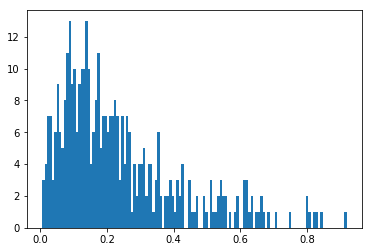

confusion matrix


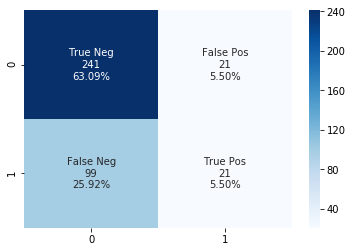

roc curve
Logistic: ROC AUC=0.650


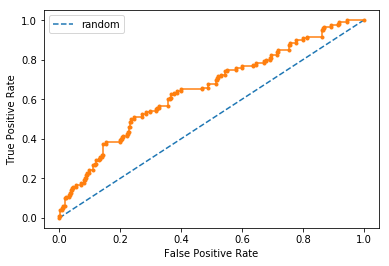

fold 1

predictions histogram


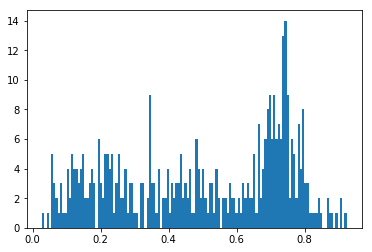

confusion matrix


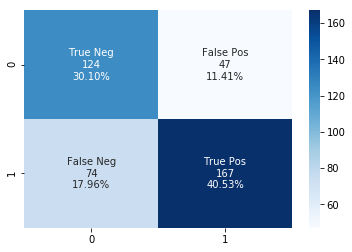

roc curve
Logistic: ROC AUC=0.774


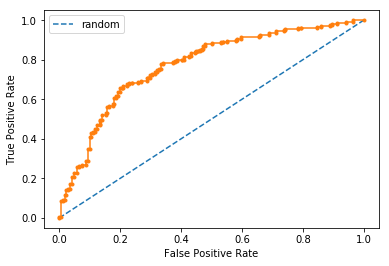

fold 2

predictions histogram


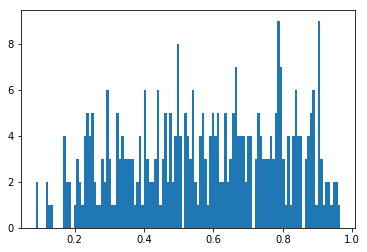

confusion matrix


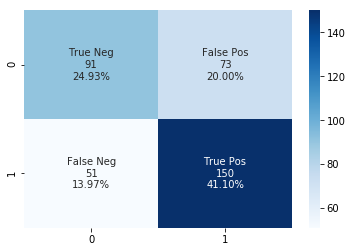

roc curve
Logistic: ROC AUC=0.700


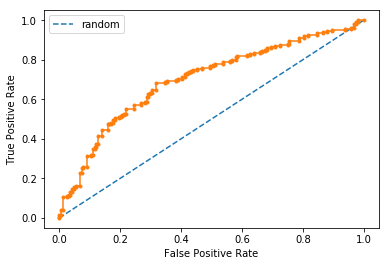

fold 3

predictions histogram


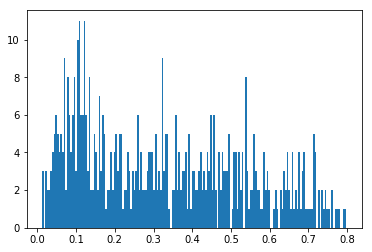

confusion matrix


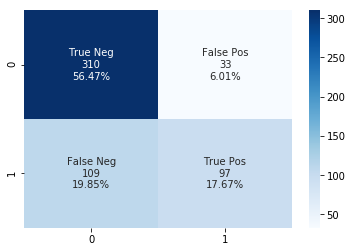

roc curve
Logistic: ROC AUC=0.820


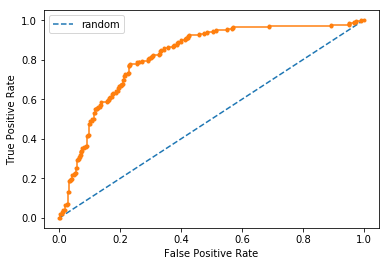

fold 4

predictions histogram


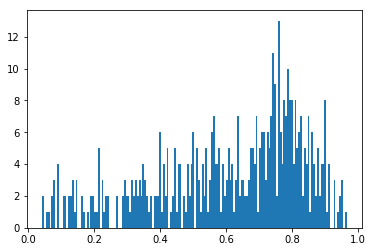

confusion matrix


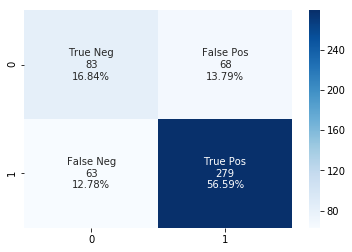

roc curve
Logistic: ROC AUC=0.758


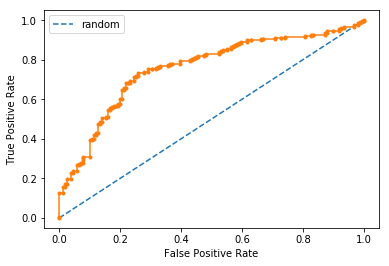

fold 5

predictions histogram


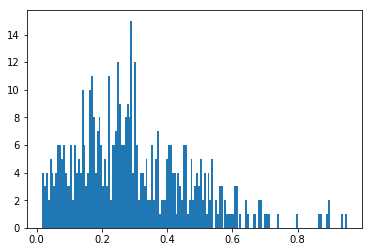

confusion matrix


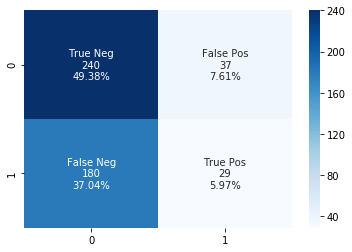

roc curve
Logistic: ROC AUC=0.532


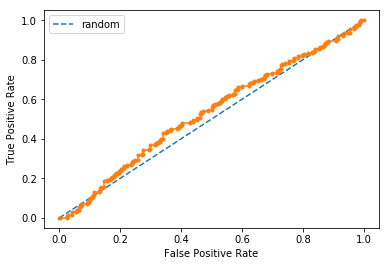

fold 6

predictions histogram


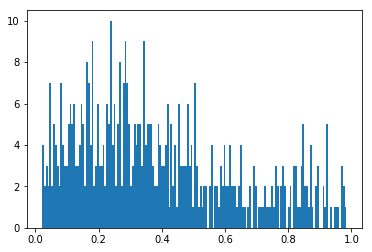

confusion matrix


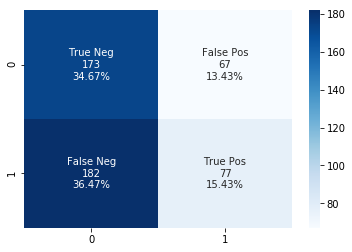

roc curve
Logistic: ROC AUC=0.494


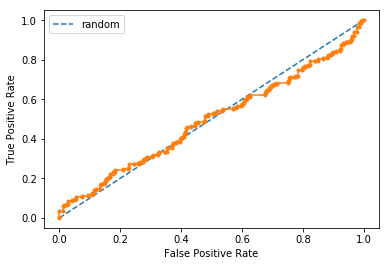

predictions histogram


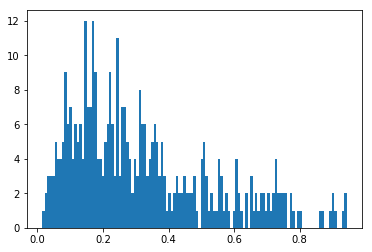

confusion matrix


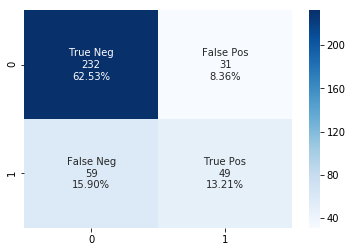

roc curve
Logistic: ROC AUC=0.792


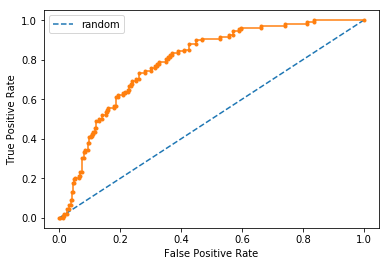

,accuracy,fn,fp,map,precision,recall,roc_auc,tn,tp
0,0.685864,99,21,0.475020,0.500000,0.175000,0.650477,241,21
1,0.706311,74,47,0.806177,0.780374,0.692946,0.774259,124,167
2,0.660274,51,73,0.735137,0.672646,0.746269,0.700006,91,150
3,0.741348,109,33,0.673731,0.746154,0.470874,0.819751,310,97
4,0.734280,63,68,0.874217,0.804035,0.815789,0.757891,83,279
5,0.553498,180,37,0.444255,0.439394,0.138756,0.531584,240,29
6,0.501002,182,67,0.557736,0.534722,0.297297,0.494498,173,77
test_set,0.757412,59,31,0.530044,0.612500,0.453704,0.792388,232,49


In [18]:
dfs = []
ave_preds = np.mean(test_preds,axis = 0)
for i, (y_pred, df_val) in enumerate(zip(val_preds, val_sets)):
    print(f'fold {i}\n')
    y_true = df_val.Binary
    dfs.append(calculate_metrics(y_true.values, y_pred.squeeze(), plots=True))
dfs.append(calculate_metrics(test_set.Binary.values, ave_preds.squeeze(), plots=True))
metrics = pd.DataFrame(dfs)
metrics.rename(index={7:'test_set'}, inplace=True)
metrics

# Calculate metrics from trained weights

In [6]:
gcn = GCN_pretraining(encoder_params,model_params)
gcn_encoder = gcn.build_encoder()
gcn_model = gcn.build_model(gcn_encoder)

LAYER 0
LAYER 1
LAYER 2


predictions histogram


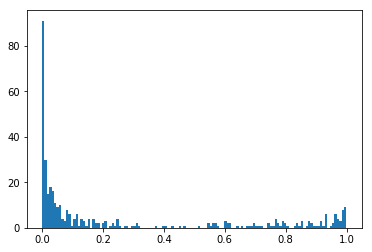

confusion matrix


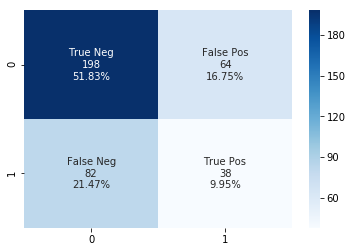

roc curve
Logistic: ROC AUC=0.591


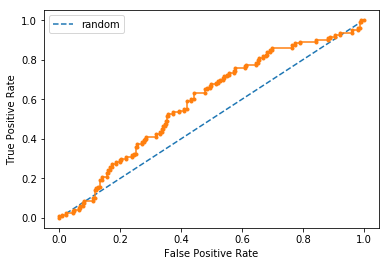

predictions histogram


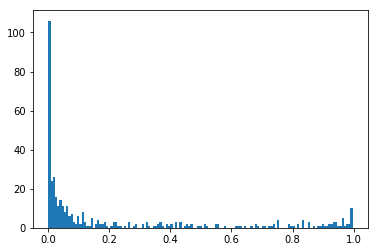

confusion matrix


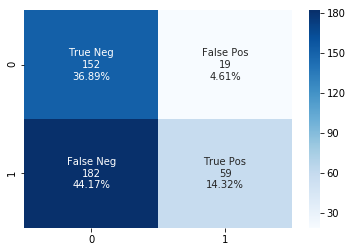

roc curve
Logistic: ROC AUC=0.601


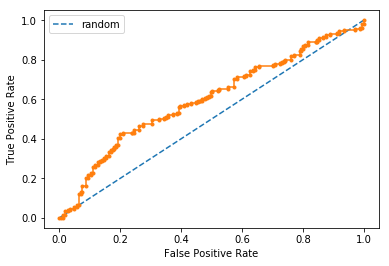

predictions histogram


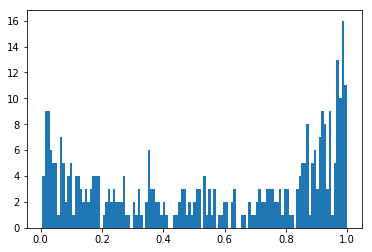

confusion matrix


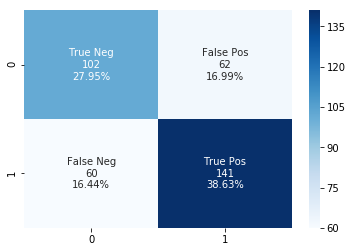

roc curve
Logistic: ROC AUC=0.727


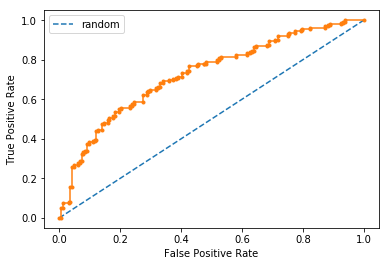

predictions histogram


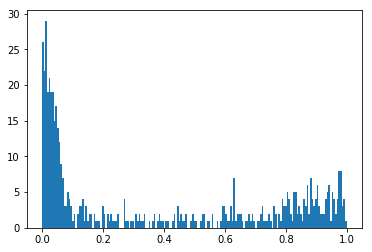

confusion matrix


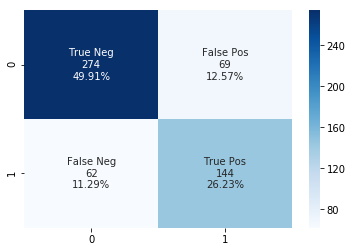

roc curve
Logistic: ROC AUC=0.840


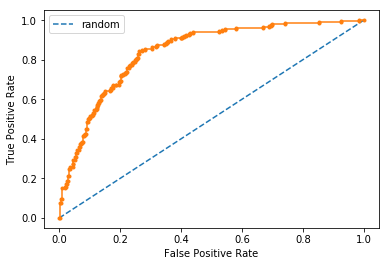

predictions histogram


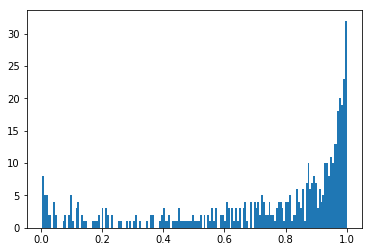

confusion matrix


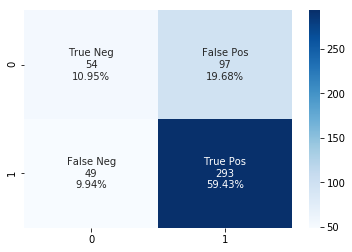

roc curve
Logistic: ROC AUC=0.726


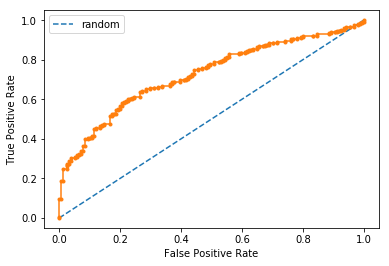

predictions histogram


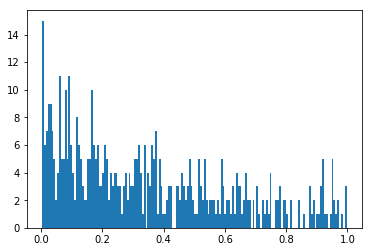

confusion matrix


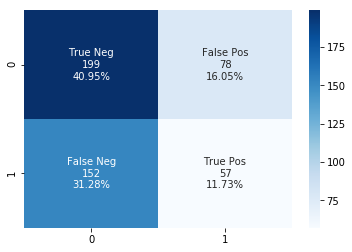

roc curve
Logistic: ROC AUC=0.529


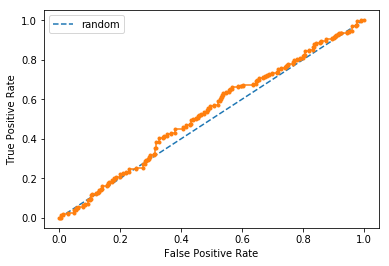

predictions histogram


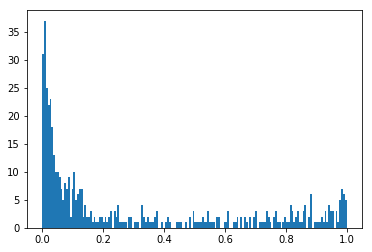

confusion matrix


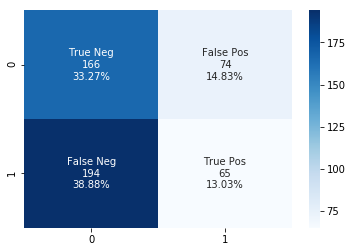

roc curve
Logistic: ROC AUC=0.445


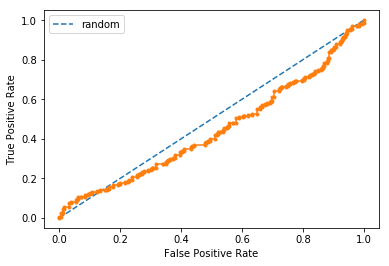

predictions histogram


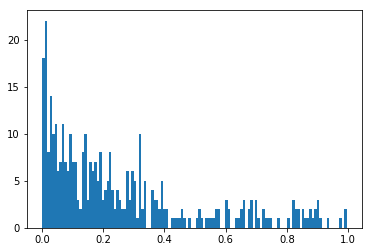

confusion matrix


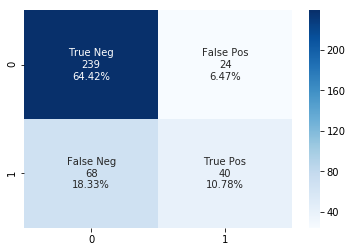

roc curve
Logistic: ROC AUC=0.807


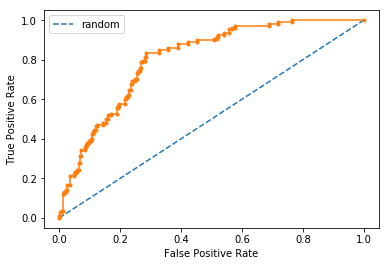

,accuracy,fn,fp,map,precision,recall,roc_auc,tn,tp
0,0.617801,82,64,0.370883,0.372549,0.316667,0.590744,198,38
1,0.512136,182,19,0.667265,0.756410,0.244813,0.601102,152,59
2,0.665753,60,62,0.749624,0.694581,0.701493,0.726520,102,141
3,0.761384,62,69,0.729064,0.676056,0.699029,0.840287,274,144
4,0.703854,49,97,0.867937,0.751282,0.856725,0.725592,54,293
5,0.526749,152,78,0.445172,0.422222,0.272727,0.528872,199,57
6,0.462926,194,74,0.514981,0.467626,0.250965,0.444884,166,65
test_set,0.752022,68,24,0.587661,0.625000,0.370370,0.806929,239,40


In [54]:
preds_val = []
preds_test = []
dfs = []
for i, df_val in enumerate(val_sets):
    y_true = df_val.Binary
    val_data = gcn.dataframe_to_gcn_input(df_val)
    gcn_model.load_weights(weight_files.format(i,i))
    pred_val = gcn_model.predict(val_data, batch_size = 1024)
    preds_val.append(pred_val)
    test_data = gcn.dataframe_to_gcn_input(test_set)
    preds_test.append(gcn_model.predict(test_data,batch_size = 1024))
    dfs.append(calculate_metrics(y_true.values, pred_val.squeeze(), plots=True))
ave_preds = np.mean(preds_test,axis = 0)
dfs.append(calculate_metrics(test_set.Binary.values, ave_preds.squeeze(), plots=True))
metrics = pd.DataFrame(dfs)
metrics.rename(index={7:'test_set'}, inplace=True)
metrics

In [56]:
metrics.to_csv(os.path.join(base_path, f'results/{target}/{model_name}/performance_metrics/performance_0.csv'))

# Evaluate ensemble from weights

In [8]:
eval_params = {
    'val_sets' : val_sets,
    'test_set' : test_set,
    'model_class': gcn,
    'model' : gcn_model,
    'model_type' : 'gcn',
    'weight_file_format' : weight_files,
    'n_ensemble' : int(10)
}

predictions histogram


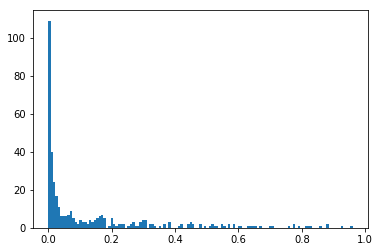

confusion matrix


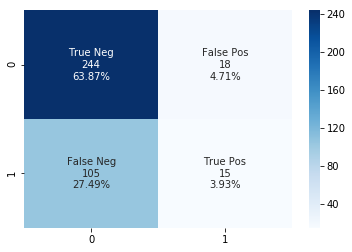

roc curve
Logistic: ROC AUC=0.590


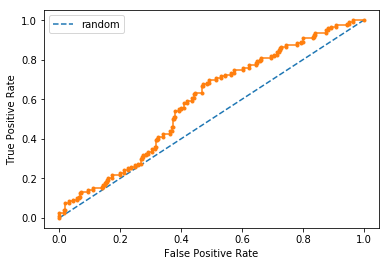

predictions histogram


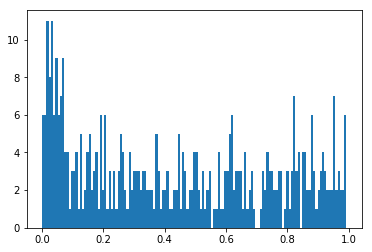

confusion matrix


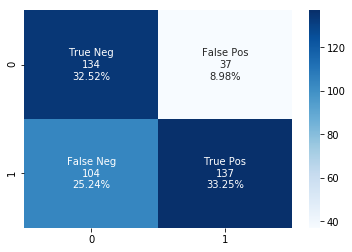

roc curve
Logistic: ROC AUC=0.711


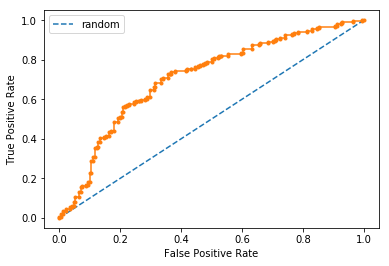

predictions histogram


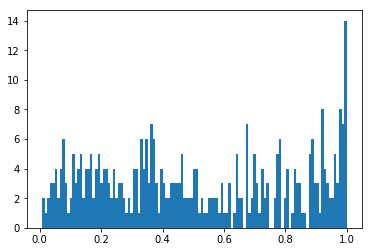

confusion matrix


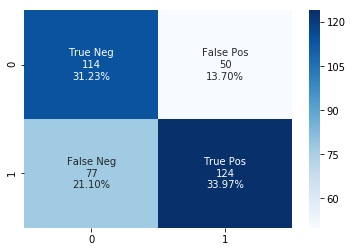

roc curve
Logistic: ROC AUC=0.704


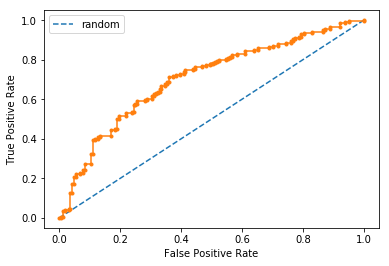

predictions histogram


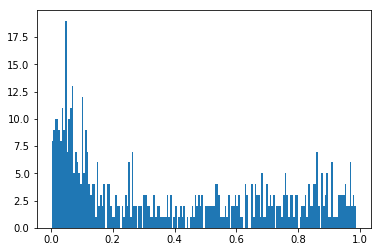

confusion matrix


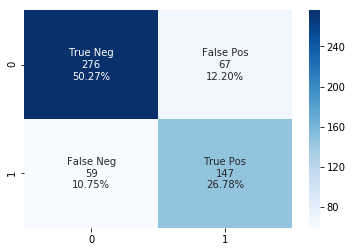

roc curve
Logistic: ROC AUC=0.838


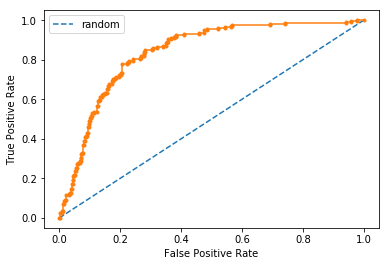

predictions histogram


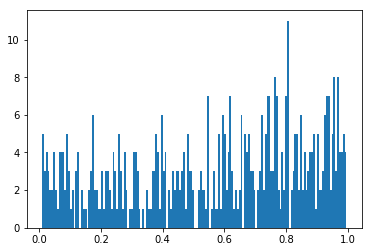

confusion matrix


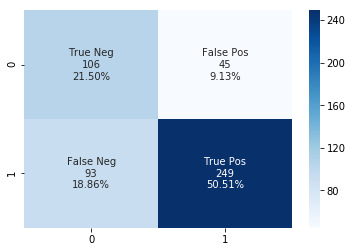

roc curve
Logistic: ROC AUC=0.778


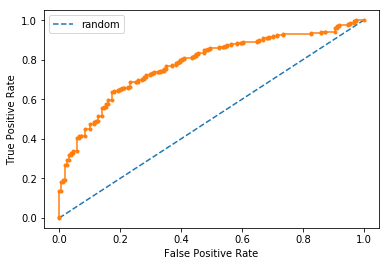

predictions histogram


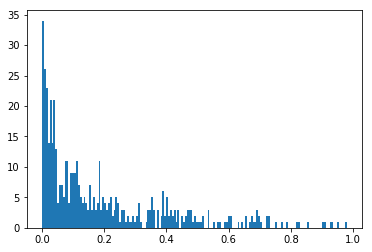

confusion matrix


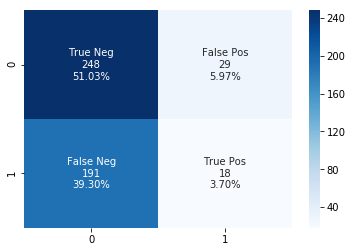

roc curve
Logistic: ROC AUC=0.536


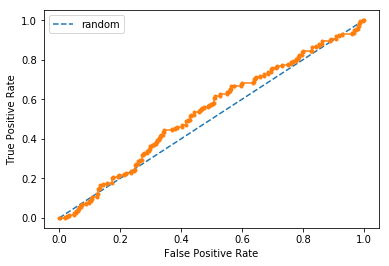

predictions histogram


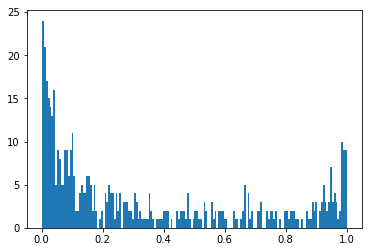

confusion matrix


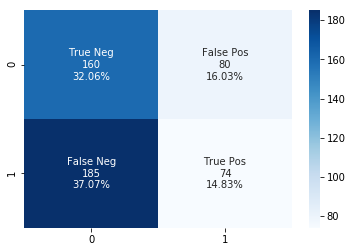

roc curve
Logistic: ROC AUC=0.443


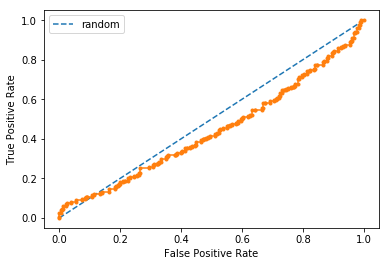

predictions histogram


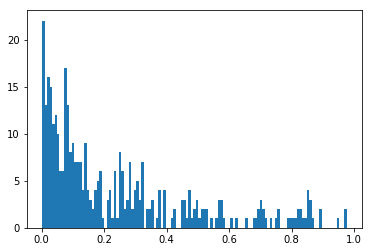

confusion matrix


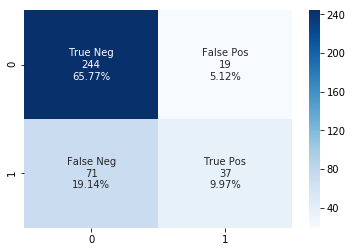

roc curve
Logistic: ROC AUC=0.824


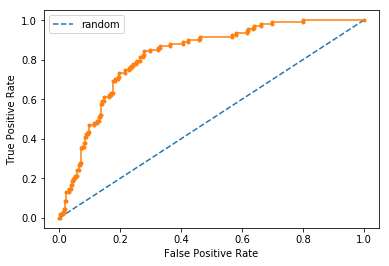

In [9]:
metrics = load_weights_and_evaluate(eval_params)

In [10]:
metrics

,accuracy,fn,fp,map,precision,recall,roc_auc,tn,tp
0,0.678010,105,18,0.393179,0.454545,0.125000,0.589917,244,15
1,0.657767,104,37,0.735880,0.787356,0.568465,0.710733,134,137
2,0.652055,77,50,0.716788,0.712644,0.616915,0.704283,114,124
3,0.770492,59,67,0.692660,0.686916,0.713592,0.837938,276,147
4,0.720081,93,45,0.892329,0.846939,0.728070,0.777797,106,249
5,0.547325,191,29,0.443435,0.382979,0.086124,0.535868,248,18
6,0.468938,185,80,0.522079,0.480519,0.285714,0.443436,160,74
test_set,0.757412,71,19,0.589354,0.660714,0.342593,0.823792,244,37
